In [1]:
pip install transformers

In [2]:
pip install datasets

In [3]:
pip install evaluate

In [4]:
#Importar librerías
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datasets
import evaluate
import seaborn as sns
import keras
from transformers import pipeline,AutoTokenizer, AutoModelForCausalLM, TFAutoModel,TFAutoModelForSequenceClassification
from transformers import BertConfig, TFBertModel,BertTokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
#Importar base de datos
dataset=pd.read_csv("dataset.csv")

In [6]:
#Primeros 5 registros del dataset
dataset.head()

,Unnamed: 0,statement,statement_paragraph,links,verdict
0,0,Una cuenta de X (Twitter) publica vide...,"El video subido a X por ByViral24, en ...",https://colombiacheck.com/chequeos/una-cuenta-...,Falso
1,1,Suplantan web de Red+ Noticias para se...,El medio de comunicación no publicó la...,https://colombiacheck.com/chequeos/suplantan-w...,Falso
2,2,Ni Mario Fernández Alcocer anunció que...,"En una supuesta noticia, el candidato ...",https://colombiacheck.com/chequeos/ni-mario-fe...,Falso
3,3,La W no filtró este supuesto audio de ...,En redes circula un video supuestament...,https://colombiacheck.com/chequeos/la-w-no-fil...,Falso
4,4,Este video no demuestra que ‘usarán la...,Se trata de una desinformación que cir...,https://colombiacheck.com/chequeos/este-video-...,Falso


In [7]:
#Columnas del dataset
dataset.columns.values

array(['Unnamed: 0', 'statement', 'statement_paragraph', 'links',
       'verdict'], dtype=object)

In [8]:
#Eliminar columnas no usadas en el dataset
dataset.drop(columns=['Unnamed: 0', 'statement','links'],axis=1,inplace=True)

In [9]:
#Identificar etiquetas
dataset['verdict'].unique()

array(['Falso', 'Cuestionable', 'Chequeo Múltiple', 'Verdadero',
       'Inchequeable', 'Verdadero pero...', 'Podcast'], dtype=object)

In [10]:
#Contar la cantidad de datos por categoria
conteo=dataset.groupby('verdict').count().reset_index()
conteo.columns=['verdict','count']
conteo=conteo.sort_values('count',ascending=False)
print(conteo)

             verdict  count
2              Falso   5955
1       Cuestionable   2026
0   Chequeo Múltiple    708
6  Verdadero pero...    576
5          Verdadero    410
4            Podcast    177
3       Inchequeable    102


In [11]:
#Verificar si hay nullos
dataset.isnull().sum()

statement_paragraph    0
verdict                0
dtype: int64

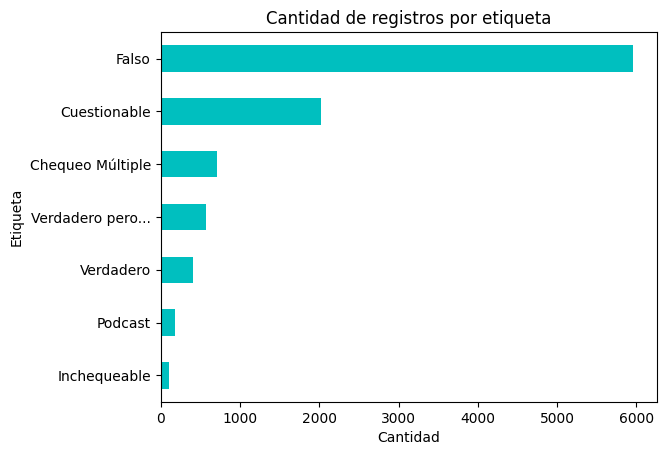

In [12]:
#Graficar la cantidad de registros por categoría
grafica = (dataset.groupby('verdict').count()).sort_values('statement_paragraph',ascending=True).plot(kind='barh',color='c')
plt.title("Cantidad de registros por etiqueta")
plt.xlabel("Cantidad")
plt.ylabel("Etiqueta")
grafica.get_legend().set_visible(False)
plt.show()

In [13]:
#Seleccionar X y y de nuestra base de datos
X=dataset['statement_paragraph']
y=dataset['verdict']

In [14]:
#Dividir el data set en tres conjuntos de datos
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20,shuffle=True, random_state=0)
X_val, X_test,y_val,y_test=train_test_split(X_val_test,y_val_test,test_size=0.5, shuffle=True,random_state=0)

In [15]:
#Transformar los datasets y
y_train=pd.get_dummies(y_train)
y_val=pd.get_dummies(y_val)
y_test=pd.get_dummies(y_test)

In [16]:
#Unir dataset
dataset_train=pd.concat([X_train,y_train],axis=1)
dataset_val=pd.concat([X_val,y_val],axis=1)
dataset_test=pd.concat([X_test,y_test],axis=1)

In [17]:
#Crear objetos tipo dataset
train_dataset = Dataset.from_dict(dataset_train)
val_dataset = Dataset.from_dict(dataset_val)
test_dataset = Dataset.from_dict(dataset_test)

In [18]:
#Crear un diccionario del data set
dataset= datasets.DatasetDict({"train":train_dataset,"val":val_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
        num_rows: 7963
    })
    val: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
        num_rows: 995
    })
    test: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
        num_rows: 996
    })
})

In [19]:
#Lista con las etiquetas
labels = [label for label in dataset['train'].features.keys() if label not in ['statement_paragraph']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Chequeo Múltiple',
 'Cuestionable',
 'Falso',
 'Inchequeable',
 'Podcast',
 'Verdadero',
 'Verdadero pero...']

In [20]:
#Preprocesamiento de los conjuntos de datos para realizar fine tune en RoBERTA - tokenization
checkpoint = "bert-base-multilingual-cased" #Selección de modelo
tokenizer = AutoTokenizer.from_pretrained(checkpoint) #Usar AutoTokenizer para

In [21]:
#Parámetros del modelo
batch_size = 32 #Tamaño del batch
num_epochs = 5 #Número de épocasa

In [22]:
#Funtion to tokenize a row in a dataset
def tokenize_function(example):
    # take a batch of texts
    text = example['statement_paragraph']
    #Encode
    encoding=tokenizer(example['statement_paragraph'], truncation=True,padding="max_length",max_length=128,return_tensors="tf")
    #add labels
    labels_batch = {k: example[k] for k in example.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
      labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix

    return encoding

In [23]:
#Aplicar la función creada a nuestros datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/7963 [00:00<?, ? examples/s]

Map:   0%|          | 0/995 [00:00<?, ? examples/s]

Map:   0%|          | 0/996 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7963
    })
    val: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 995
    })
    test: Dataset({
        features: ['statement_paragraph', 'Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 996
    })
})

In [24]:
#Convetir base de objetos tipo datasets a dataset compatible con tensorflow
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=['labels'],
    #label_cols=['Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
    shuffle=True,
    batch_size=batch_size,
)

tf_validation_dataset = tokenized_datasets["val"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=['labels'],
    #label_cols=['Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
    shuffle=False,
    batch_size=batch_size,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=['labels'],
    #label_cols=['Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...'],
    shuffle=False,
    batch_size=batch_size,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [25]:
#Inicializar modelo
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                             num_labels=7,
                                                             #id2label=id2label,
                                                             #label2id=label2id
                                                            )

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#Tasa de aprendizaje
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

#Optimizador
opt = Adam(learning_rate=lr_scheduler)

#Función de perdida
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [27]:
#Compilación del modelo
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=["accuracy"],
)

In [28]:
#Entrenamiento del modelo
Model=model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    )

Epoch 1/5
249/249 [==============================] - 116s 301ms/step - loss: 0.9532 - accuracy: 0.6768 - val_loss: 0.7393 - val_accuracy: 0.7457
Epoch 2/5
249/249 [==============================] - 72s 290ms/step - loss: 0.5038 - accuracy: 0.8357 - val_loss: 0.3962 - val_accuracy: 0.8804
Epoch 3/5
249/249 [==============================] - 72s 290ms/step - loss: 0.2019 - accuracy: 0.9430 - val_loss: 0.2054 - val_accuracy: 0.9487
Epoch 4/5
249/249 [==============================] - 72s 290ms/step - loss: 0.0684 - accuracy: 0.9856 - val_loss: 0.1363 - val_accuracy: 0.9658
Epoch 5/5
249/249 [==============================] - 72s 290ms/step - loss: 0.0335 - accuracy: 0.9946 - val_loss: 0.1260 - val_accuracy: 0.9698


In [29]:
#Calcular prediciones
preds = model.predict(tf_test_dataset)["logits"]
probabilities=tf.nn.softmax(preds)
class_preds=np.argmax(probabilities,axis=1)
print(preds.shape, class_preds.shape)

32/32 [==============================] - 6s 96ms/step
(996, 7) (996,)


In [30]:
#Transformación al conjunto de test
y_test_2=y_test
y_test_2.columns=[0,1,2,3,4,5,6]
y_test_2=y_test_2.to_numpy()
y_test_ver=np.argmax(y_test_2,axis=1)

In [31]:
#Métricas de evaluación
class_labels=['Chequeo Múltiple', 'Cuestionable', 'Falso', 'Inchequeable', 'Podcast', 'Verdadero', 'Verdadero pero...']
report = classification_report(class_preds, y_test_ver, target_names=class_labels)
print(report)

                   precision    recall  f1-score   support

 Chequeo Múltiple       0.95      0.98      0.97        60
     Cuestionable       0.96      0.97      0.97       197
            Falso       0.99      0.98      0.99       612
     Inchequeable       1.00      0.88      0.93         8
          Podcast       0.90      1.00      0.95        19
        Verdadero       1.00      0.92      0.96        38
Verdadero pero...       0.94      1.00      0.97        62

         accuracy                           0.98       996
        macro avg       0.96      0.96      0.96       996
     weighted avg       0.98      0.98      0.98       996



Text(113.4222222222222, 0.5, 'predicted label')

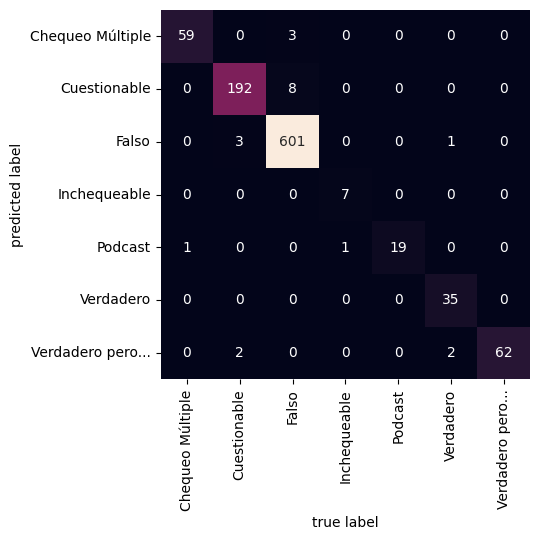

In [32]:
#Matriz de confusión
mat=confusion_matrix(class_preds, y_test_ver)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

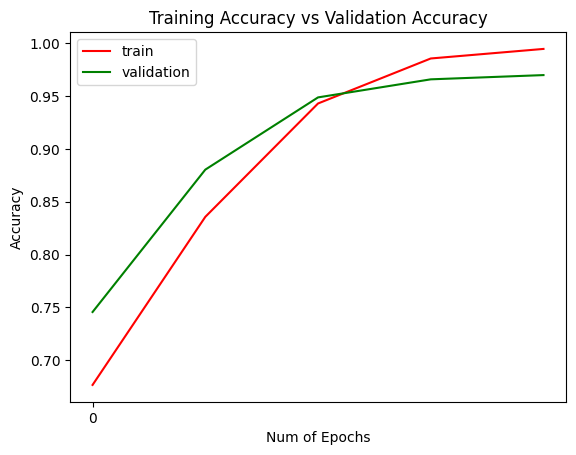

In [33]:
#Accuracy training dataset vs test dataset
plt.figure(0)
plt.plot(Model.history['accuracy'],'r')
plt.plot(Model.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 20, 100))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

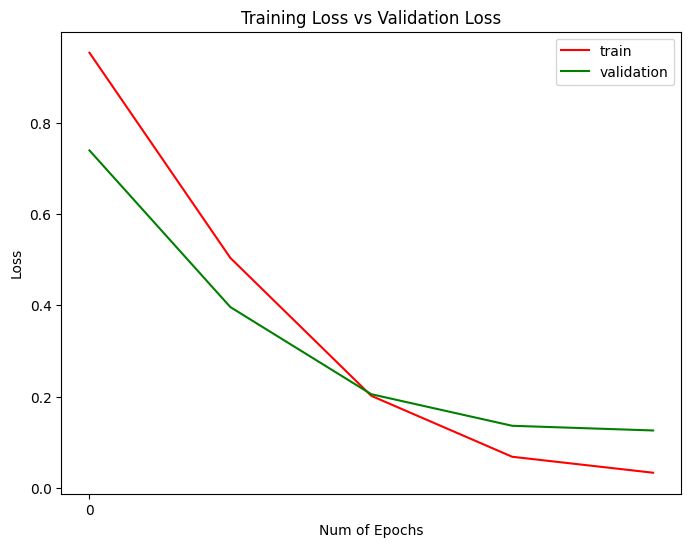

In [34]:
#Función de pérdida training dataset vs test dataset
plt.figure(1)
plt.plot(Model.history['loss'],'r')
plt.plot(Model.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 100))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


In [35]:
model.export("/content/")

Saved artifact at '/content/'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: {'attention_mask': <1>, 'input_ids': <2>, 'token_type_ids': <3>}
      <1>: int32 Tensor, shape=(None, None)
      <2>: int32 Tensor, shape=(None, None)
      <3>: int32 Tensor, shape=(None, None)
  Returns:
    TFSequenceClassifierOutput(loss=None, logits=<1>, hidden_states=None, attentions=None)
      <1>: float32 Tensor, shape=(None, 7)
